## 1) Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.utils.data import random_split

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
#from resources.plotcm import plot_confusion_matrix

import time
import random

import itertools

In [ ]:
torch.cuda.get_device_name(device=None)

'Tesla P100-PCIE-16GB'

In [ ]:
path = f'./benchmark/cm/lenet5/train'
if not os.path.exists(path):
    os.makedirs(path)

path = f'./benchmark/cm/lenet5/test'
if not os.path.exists(path):
    os.makedirs(path)

## 2) Definitions

### 2.1) Activation Functions

#### 2.1.1) Squashing Function

In [ ]:
# implement class wrapper for squashing activation function
class Squashing(nn.Module):
    def __init__(self, learnable=True, beta=0.1):
        '''
        Init method.
        '''
        super(Squashing, self).__init__()

        # initialize fix parameters
        self.alpha = 0.5
        self.lam = 1.0


        if learnable:
            # initialize beta as learnable parameter
            self.beta = Parameter(torch.tensor(beta))
            self.beta.requiresGrad = True
        else:
            # static value
            self.beta = torch.tensor(beta)
            self.beta.requiresGrad = False

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        #print("Beta:", self.beta.data.item())
        global betas
        #global f_beta 
        #global f_alpha 
        #global f_lam 
        #f_beta= self.beta
        #f_alpha= self.alpha
        #f_lam= self.lam 


        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )



# implement mish activation function
def f_squashing(input):
  slam = f_lam
  sbeta = f_beta
  salpha = f_alpha
  return (1/(slam * sbeta)) * torch.log( (1+torch.exp(sbeta*(input-(salpha-(slam/2)))) ) / (1+torch.exp(sbeta*(input-(salpha+(slam/2))))) )

### 2.2) Network

### 2.2.1) LeNet-5

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, activation = 'squashing'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.out = nn.Linear(in_features=84, out_features=10)
        
        if activation == 'relu':
            print("relu")
            self.f_activation = nn.ReLU()
            
        if activation == 'sigmoid':
            print("sigmoid")
            self.f_activation = nn.Sigmoid()
            
        if activation == 'tanh':
            print("tanh")
            self.f_activation = nn.Tanh()
            
        if activation == 'squashing':
            print("squashing")
            self.f_activation = Squashing()
            
        if (activation == 'squashing-nl'):
            print("squashing-nl")
            self.f_activation = Squashing(False, beta=0.6)
    
    def forward(self, x):
        # (1) input layer
        x = x

        # (2) hidden conv Layer
        x = self.conv1(x)
        x = self.f_activation(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)

        #(3) hidden conv Layer
        x = self.conv2(x)
        x = self.f_activation(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)

        # (4) hidden linear Layer
        x = x.reshape(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x = self.f_activation(x)

        # (5) hidden linear Layer
        x = self.fc2(x)
        x = self.f_activation(x)

        #(6) output Layer
        x = self.out(x)

        return x

### 2.3) Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, activation='relu', network='lenet', step='train'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'./benchmark/cm/{network}/{step}/fashion-mnist_{network}_{activation}_{step}_{int(time.time())}.png', dpi=300, transparent=True, bbox_inches='tight')

## 3) Parameter

In [ ]:
epochs = 50
batch_size = 32
learning_rate = 0.0001

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

# lenet5, resnext50
network = 'lenet5'

#squashing, squashing-nl, relu, sigmoid, swish
activation = 'tanh'

# LeNet5(activation), resnext50(activation=activation)
model = LeNet5(activation)

# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

tanh


In [ ]:
device

device(type='cuda', index=0)

## 4) Datasets

In [ ]:
# definie train dataloader
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size)

# definie test dataloader
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=batch_size)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## 5) Training

In [ ]:
train_stats = pd.DataFrame()

#train the model
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # calculate train top-1 accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # Calculate train top-3 accuracy
        np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = labels.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    top3_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Calculate test top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
          f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}.. "
          #f"Beta: {betas:.4f}"
          )

    if 'betas' in globals():
      train_stats = train_stats.append({'Epoch': int(epoch+1), 'Time per epoch':time_elapsed,
                                        'Avg time per step': time_elapsed/len(trainloader),
                                        'Train loss' : running_loss/len(trainloader),
                                        'Train accuracy': train_accuracy/len(trainloader),
                                        'Train top-3 accuracy':top3_train_accuracy/len(trainloader),
                                        'Test loss' : test_loss/len(testloader),
                                        'Test accuracy': test_accuracy/len(testloader),
                                        'Test top-3 accuracy':top3_test_accuracy/len(testloader),
                                        'Beta': betas
                                        }, ignore_index=True)
    else:
      train_stats = train_stats.append({'Epoch': int(epoch+1), 'Time per epoch':time_elapsed,
                                        'Avg time per step': time_elapsed/len(trainloader),
                                        'Train loss' : running_loss/len(trainloader),
                                        'Train accuracy': train_accuracy/len(trainloader),
                                        'Train top-3 accuracy':top3_train_accuracy/len(trainloader),
                                        'Test loss' : test_loss/len(testloader),
                                        'Test accuracy': test_accuracy/len(testloader),
                                        'Test top-3 accuracy':top3_test_accuracy/len(testloader)
                                        }, ignore_index=True)
    
    
    
    running_loss = 0
    model.train()





Epoch 1/50.. Time per epoch: 11.8988.. Average time per step: 0.0063.. Train loss: 0.9385.. Train accuracy: 0.6717.. Top-3 train accuracy: 0.9341.. Test loss: 0.6700.. Test accuracy: 0.7534.. Top-3 test accuracy: 0.9711.. 
Epoch 2/50.. Time per epoch: 11.0354.. Average time per step: 0.0059.. Train loss: 0.5885.. Train accuracy: 0.7828.. Top-3 train accuracy: 0.9767.. Test loss: 0.5711.. Test accuracy: 0.7825.. Top-3 test accuracy: 0.9751.. 
Epoch 3/50.. Time per epoch: 10.9983.. Average time per step: 0.0059.. Train loss: 0.5159.. Train accuracy: 0.8134.. Top-3 train accuracy: 0.9811.. Test loss: 0.5190.. Test accuracy: 0.8089.. Top-3 test accuracy: 0.9775.. 
Epoch 4/50.. Time per epoch: 11.6234.. Average time per step: 0.0062.. Train loss: 0.4725.. Train accuracy: 0.8290.. Top-3 train accuracy: 0.9828.. Test loss: 0.4820.. Test accuracy: 0.8231.. Top-3 test accuracy: 0.9816.. 
Epoch 5/50.. Time per epoch: 11.4151.. Average time per step: 0.0061.. Train loss: 0.4434.. Train accura

## 6) Output

In [ ]:
train_stats.to_csv(f'./benchmark/fashion-mnist_{network}_{activation}_{int(time.time())}.csv')

## 7) Confusion Matrix

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images=images.to(device)
        labels=labels.to(device)
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

### 7.1) Train Set

In [ ]:
len(trainset)

60000

In [ ]:
len(trainset.targets)

60000

In [ ]:
with torch.no_grad():
    train_prediction_loader=torch.utils.data.DataLoader(trainset, batch_size=1000)
    train_preds=get_all_preds(model, train_prediction_loader).to(device)

In [ ]:
stacked_train = torch.stack(
    (
        trainset.targets.to(device),
        train_preds.argmax(dim=1)
    ),dim=1
)

In [ ]:
cmtr = torch.zeros(10,10, dtype=torch.int64)
for p in stacked_train:
    true, predicted = p.tolist()
    cmtr[true, predicted] = cmtr[true, predicted] + 1

In [ ]:
cmtr

tensor([[5534,    7,   61,  102,   13,    2,  271,    0,   10,    0],
        [   4, 5939,    3,   43,    5,    0,    4,    0,    2,    0],
        [  56,    2, 4972,   56,  570,    0,  339,    0,    5,    0],
        [ 109,   23,   27, 5604,  188,    0,   44,    0,    5,    0],
        [   7,    4,  225,  164, 5357,    0,  240,    0,    3,    0],
        [   0,    0,    0,    0,    0, 5943,    1,   50,    1,    5],
        [ 851,   11,  285,  109,  360,    0, 4375,    0,    9,    0],
        [   0,    0,    0,    0,    0,   39,    0, 5908,    0,   53],
        [   9,    0,    9,    8,   19,    0,   12,    1, 5942,    0],
        [   0,    0,    0,    0,    0,   18,    0,  189,    2, 5791]])

Confusion matrix, without normalization
tensor([[5534,    7,   61,  102,   13,    2,  271,    0,   10,    0],
        [   4, 5939,    3,   43,    5,    0,    4,    0,    2,    0],
        [  56,    2, 4972,   56,  570,    0,  339,    0,    5,    0],
        [ 109,   23,   27, 5604,  188,    0,   44,    0,    5,    0],
        [   7,    4,  225,  164, 5357,    0,  240,    0,    3,    0],
        [   0,    0,    0,    0,    0, 5943,    1,   50,    1,    5],
        [ 851,   11,  285,  109,  360,    0, 4375,    0,    9,    0],
        [   0,    0,    0,    0,    0,   39,    0, 5908,    0,   53],
        [   9,    0,    9,    8,   19,    0,   12,    1, 5942,    0],
        [   0,    0,    0,    0,    0,   18,    0,  189,    2, 5791]])


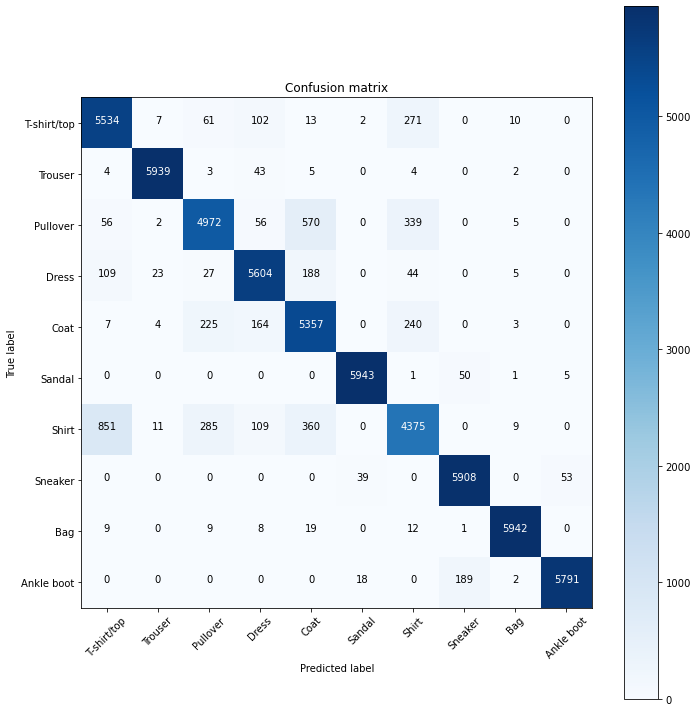

In [ ]:
names_train = tuple(trainset.classes)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cmtr, names_train, activation=activation, network=network, step='train')

### 7.2) Test Set

In [ ]:
len(testset)

10000

In [ ]:
len(testset.targets)

10000

In [ ]:
with torch.no_grad():
    test_prediction_loader=torch.utils.data.DataLoader(testset, batch_size=1000)
    test_preds=get_all_preds(model, test_prediction_loader).to(device)

In [ ]:
stacked_test = torch.stack(
    (
        testset.targets.to(device),
        test_preds.argmax(dim=1)
    ),dim=1
)

In [ ]:
cmte = torch.zeros(10,10, dtype=torch.int64)
#cmt
for p in stacked_test:
    true, predicted = p.tolist()
    cmte[true, predicted] = cmte[true, predicted] + 1

In [ ]:
cmte

tensor([[885,   0,  13,  23,   3,   1,  68,   0,   7,   0],
        [  5, 975,   1,  11,   4,   0,   4,   0,   0,   0],
        [ 15,   0, 793,  15,  99,   0,  76,   0,   2,   0],
        [ 21,  15,   9, 907,  32,   0,  11,   0,   5,   0],
        [  1,   1,  53,  39, 840,   0,  65,   0,   1,   0],
        [  0,   0,   0,   1,   0, 973,   0,  19,   0,   7],
        [158,   1,  65,  29,  75,   0, 665,   0,   7,   0],
        [  0,   0,   0,   0,   0,  17,   0, 969,   0,  14],
        [  6,   0,   2,   4,   3,   1,   3,   5, 976,   0],
        [  1,   0,   0,   0,   0,  11,   0,  44,   0, 944]])

Confusion matrix, without normalization
tensor([[885,   0,  13,  23,   3,   1,  68,   0,   7,   0],
        [  5, 975,   1,  11,   4,   0,   4,   0,   0,   0],
        [ 15,   0, 793,  15,  99,   0,  76,   0,   2,   0],
        [ 21,  15,   9, 907,  32,   0,  11,   0,   5,   0],
        [  1,   1,  53,  39, 840,   0,  65,   0,   1,   0],
        [  0,   0,   0,   1,   0, 973,   0,  19,   0,   7],
        [158,   1,  65,  29,  75,   0, 665,   0,   7,   0],
        [  0,   0,   0,   0,   0,  17,   0, 969,   0,  14],
        [  6,   0,   2,   4,   3,   1,   3,   5, 976,   0],
        [  1,   0,   0,   0,   0,  11,   0,  44,   0, 944]])


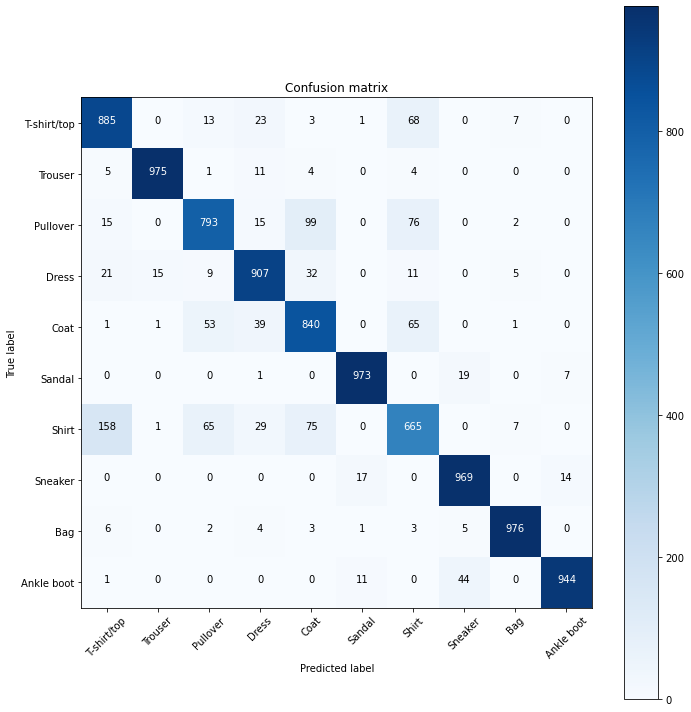

In [ ]:
names_test = tuple(testset.classes)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cmte, names_test, activation=activation, network=network, step='test')

### 7.3) Save CM train and test

In [ ]:
torch.save(train_preds, f'./benchmark/cm/train_preds_{network}_{activation}.pt')
# torch.load(f'storage/benchmarks/cm/train_preds_{network}_{activation}.pt')

In [ ]:
torch.save(test_preds, f'./benchmark/cm/test_preds_{network}_{activation}.pt')
# torch.load(f'storage/benchmarks/cm/train_preds_{network}_{activation}.pt')